## Sentiment Analysis

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [9]:
import numpy as np
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

<class 'pandas.core.frame.DataFrame'>
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...
3  airport    starts as a brand new luxury    pla...
4  brilliant over  acting by lesley ann warren . ...


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import keras_tuner as kt
import matplotlib.pyplot as plt
from pathlib import Path

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing. Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

We will first split the data and then apply CounVectorizer, so we can prevent any data leakage.

We will do some data preprocessing, so the model yells the best results.


In [11]:
# Split data into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews[0], Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert the reviews into a bag of words
vectorizer = CountVectorizer(max_features=10000)
X_train = vectorizer.fit_transform(X_train)
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

**(b)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

In [12]:
X_train

<16000x10000 sparse matrix of type '<class 'numpy.int64'>'
	with 2010883 stored elements in Compressed Sparse Row format>

We got a Sparse Matrix as a result in which each row is a review and each column is one of the 10 000 most frequent words we set in the CountVectorizer. Each value represents how many times a given word appear in a given review.

In [13]:
print(X_train[0])

# Get the feature names (words) from the vectorizer
feature_names = vectorizer.get_feature_names_out()

# Print the first word
print("First word in the vocabulary:", feature_names[8954])

  (0, 8954)	5
  (0, 5652)	1
  (0, 4894)	1
  (0, 1731)	2
  (0, 6163)	4
  (0, 7662)	1
  (0, 9073)	1
  (0, 9680)	1
  (0, 1826)	1
  (0, 3518)	2
  (0, 4722)	2
  (0, 9312)	1
  (0, 8007)	1
  (0, 8334)	1
  (0, 2847)	1
  (0, 1206)	2
  (0, 1769)	1
  (0, 9079)	2
  (0, 9760)	1
  (0, 7764)	1
  (0, 5378)	1
  (0, 3748)	1
  (0, 9434)	1
  (0, 8995)	2
  (0, 4301)	1
  :	:
  (0, 9772)	1
  (0, 6861)	1
  (0, 9748)	1
  (0, 1353)	1
  (0, 5088)	1
  (0, 6203)	1
  (0, 8981)	1
  (0, 4473)	2
  (0, 6398)	1
  (0, 2667)	1
  (0, 6268)	1
  (0, 5859)	1
  (0, 9905)	1
  (0, 5851)	1
  (0, 6446)	1
  (0, 4903)	1
  (0, 505)	1
  (0, 9151)	1
  (0, 2606)	1
  (0, 4709)	1
  (0, 6408)	1
  (0, 5603)	1
  (0, 8203)	1
  (0, 4196)	1
  (0, 7537)	1
First word in the vocabulary: the


As we can see 'the' is the more common word in the 1st sentence. We checked and it it thesame case for the 2nd and pretty sure for many others. So each record in the Sparse Matrix represents how many times a given word is contained in a given sentence/review. We tried to format the text by removing commmon words as the, these, etc but there was no improvement in the model, so we decided that we will stick to the original data.

**(c)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

In [14]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPU found. Using CPU instead.")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [15]:
tf.random.set_seed(42)
# Hyperparameter tuning function
def build_model(hp):
    model = Sequential()

    # First layer with hyperparameter tuning
    model.add(Dense(
    units=hp.Int('units', min_value=16, max_value=128, step=16),
    activation='leaky_relu',
    kernel_regularizer=l2(hp.Float('l2_regularizer', min_value=0.0001, max_value=0.01, step=0.0001)),
    input_shape=(X_train.shape[1],)
    ))

    # Output layer
    model.add(Dense(2, activation='sigmoid')) # Adjust for multi-class classificat
    # Learning rate decay schedule with hyperparameter tuning
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hp.Float('initial_learning_rate', min_value=1e-5, max_value=1e-2, sampling='log'),
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
    )
    
    # Compile model with optimizer and decay schedule
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# Convert the labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=2)
# Set up the Keras Tuner
tuner = kt.Hyperband(
build_model,
objective='val_accuracy',
max_epochs=30,
factor=3,
hyperband_iterations=4,
directory='my_dir',
project_name='hyperparameter_tuning'
)

# Callbacks
root_logdir = Path(tuner.project_dir) / "tensorboard"
tensorboard_cb = TensorBoard(
log_dir=root_logdir,
update_freq=1000,
histogram_freq=0
)

early_stopping_cb = EarlyStopping(
monitor='val_loss',
patience=3,
restore_best_weights=True
)

checkpoint_cb = ModelCheckpoint(
filepath='model_checkpoints/trial_{trial_id}_epoch_{epoch}',
save_weights_only=True,
monitor='val_accuracy',
mode='max',
save_best_only=True,

)

X_train_dense = X_train. toarray ()
X_val_dense = X_val. toarray()

tuner. search(
    X_train_dense, y_train_one_hot,
    epochs=20,
    batch_size=50,
    validation_data=(X_val_dense, y_val_one_hot),
    callbacks=[early_stopping_cb, tensorboard_cb]
)

INFO:tensorflow:Reloading Tuner from my_dir\hyperparameter_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [16]:
# %tensorboard --logdir=./my_dir

In [17]:
# Save the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_params = tuner.get_best_hyperparameters(num_trials=1)[0]
best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
best_optimizer = best_model.optimizer
print("\nBest optimizer:")
print(best_optimizer)

print("\nBest hyperparameters:")
print(best_params.values)
print("\nBest trial:")
print(best_trial.trial_id)
print("\nBest model:")
print(best_model.summary())
history_loss = best_trial.metrics.get_history('loss')
history_val_loss = best_trial.metrics.get_history('val_loss')
best_model.save('best_model.h5')
# Save the best optimizer configuration
optimizer_config = best_optimizer.get_config()
np.save('best_optimizer_config.npy', optimizer_config)


Best optimizer:

Best hyperparameters:
{'units': 48, 'l2_regularizer': 0.0016, 'initial_learning_rate': 7.73297757996155e-05, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}

Best trial:
0067

Best model:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                480048    
                                                                 
 dense_1 (Dense)             (None, 2)                 98        
                                                                 
Total params: 480,146
Trainable params: 480,146
Non-trainable params: 0
_________________________________________________________________
None


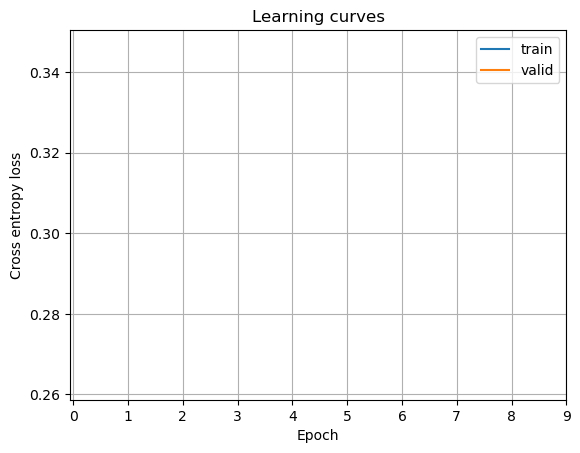

In [18]:
# Extract float values from MetricObservation objects
history_loss_values = [obs.value for obs in history_loss]
history_val_loss_values = [obs.value for obs in history_val_loss]
plt.figure()
plt.title("Learning curves")
plt.xlabel("Epoch")
plt.ylabel("Cross entropy loss")
plt.plot(history_loss_values, label='train')
plt.plot(history_val_loss_values, label='valid')
plt.xticks(range(0, best_params['tuner/epochs'], 1))
plt.grid()
plt.legend()
plt.show()

In [19]:
model = tf.keras.models.load_model('best_model.h5', compile=False)
# Learning rate decay schedule with hyperparameter tuning
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=0.001,
decay_steps=100000,
decay_rate=0.96,
)
# Compile model with optimizer and decay schedule
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
# Evaluate the model
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=2)
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("\nTest loss:", test_accuracy)


Test loss: 0.8877999782562256


In [20]:
# Load the best model
# best_model = tf.keras.models.load_model('sentiment_model.h5')
val_loss, val_accuracy = best_model.evaluate(X_val, y_val_one_hot, verbose=0)
print("Best model validation accuracy:", val_accuracy)

Best model validation accuracy: 0.8927500247955322


**(d)** Test your sentiment-classifier on the test set.

In [21]:
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=2)
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot, verbose=0)
print("Test set accuracy:", test_accuracy)

Test set accuracy: 0.8877999782562256


**(e)** Use the classifier to classify a few sentences you write yourselves. 

In [22]:
sample_sentences = [
"This movie was fantastic! I really enjoyed it.",
"The film was terrible and a waste of time.",
"An average movie with some good and bad moments.",
"Absolutely loved the storyline and the characters.",
"I did not like the movie at all."
]

sample_sentences_transformed = vectorizer.transform(sample_sentences)

predictions = model.predict(sample_sentences_transformed)

for sentence, pred in zip(sample_sentences, predictions):
    positive_confidence = pred[1] * 100
    negative_confidence = pred[0] * 100
    predicted_label = 'positive' if positive_confidence > 50 else 'negative'
    print(f"Sentence: {sentence}\nPredicted Sentiment: {predicted_label} ({positive_confidence:.2f}% positive, {negative_confidence:.2f}% negative)\n")

1/1 [==============================] - 0s 88ms/step
Sentence: This movie was fantastic! I really enjoyed it.
Predicted Sentiment: positive (67.27% positive, 32.60% negative)

Sentence: The film was terrible and a waste of time.
Predicted Sentiment: negative (22.89% positive, 75.72% negative)

Sentence: An average movie with some good and bad moments.
Predicted Sentiment: negative (40.94% positive, 58.61% negative)

Sentence: Absolutely loved the storyline and the characters.
Predicted Sentiment: positive (54.81% positive, 45.77% negative)

Sentence: I did not like the movie at all.
Predicted Sentiment: negative (44.77% positive, 54.95% negative)

